<a href="https://colab.research.google.com/github/benjaminsw/generic-VI/blob/main/VI_code_sample_1_02_GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this notebook, I aim to examine generic variational inference code. The first code is from: https://zhiyzuo.github.io/VI/

1.01:
- generalised plot
- scale param in <code>np.random.normal()</code>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## ELBO term in 'get_elbo(self)':
$\mathcal{L}_{\theta,\phi}(\mathbf{x})=\mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})}[\log p_{\theta}(\mathbf{x},\mathbf{z})+ \mathcal{H}(q)\ (entropy\ of\ q) $



* The first term prefers q(z) to be high when complete likelihood p(x,z) is high
* The second term encourages q(z) to be diffuse across the space




In [ ]:
class UGMM(object):
    '''Univariate GMM with CAVI'''
    def __init__(self, X, K=2, sigma=1):
        self.X = X
        self.K = K
        self.N = self.X.shape[0]                                                # number of rows in X
        self.sigma2 = sigma**2

    def _init(self):
        self.phi = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*self.K, self.N)
        self.m = np.random.randint(int(self.X.min()), high=int(self.X.max()), size=self.K).astype(float)
        self.m += self.X.max()*np.random.random(self.K)                         # generate means in accordance with the number of K
        self.s2 = np.ones(self.K) * np.random.random(self.K)                    # generate variences in accordance with the number of K
        print('Init mean') # print means
        print(self.m)
        print('Init s2') # print varience
        print(self.s2)
        print('Init N') # print number of rows
        print(self.N)
        print('Init X') # print X
        print(self.X)
        print('range of X (min-max)')
        print([self.X.min(), self.X.max()])
        print('---End Init---')

    def get_elbo(self):
        t1 = np.log(self.s2) - self.m/self.sigma2
        t1 = t1.sum()
        t2 = -0.5*np.add.outer(self.X**2, self.s2+self.m**2)
        t2 += np.outer(self.X, self.m)
        t2 -= np.log(self.phi)
        t2 *= self.phi
        t2 = t2.sum()
        return t1 + t2

    def fit(self, max_iter=100, tol=1e-10):
        self._init()
        self.elbo_values = [self.get_elbo()]
        self.m_history = [self.m]
        self.s2_history = [self.s2]
        for iter_ in range(1, max_iter+1):
            self._cavi()
            self.m_history.append(self.m)
            self.s2_history.append(self.s2)
            self.elbo_values.append(self.get_elbo())
            if iter_ % 5 == 0:
                print(iter_, self.m_history[iter_])
            if np.abs(self.elbo_values[-2] - self.elbo_values[-1]) <= tol:
                print('ELBO converged with ll %.3f at iteration %d'%(self.elbo_values[-1],
                                                                     iter_))
                break

        if iter_ == max_iter:
            print('ELBO ended with ll %.3f'%(self.elbo_values[-1]))


    def _cavi(self):
        self._update_phi()
        self._update_mu()

    def _update_phi(self):  #  phi is a vector of probabilities of data belonging to K_i component
        t1 = np.outer(self.X, self.m)
        t2 = -(0.5*self.m**2 + 0.5*self.s2)
        exponent = t1 + t2[np.newaxis, :]
        self.phi = np.exp(exponent)
        self.phi = self.phi / self.phi.sum(1)[:, np.newaxis]

    def _update_mu(self):
        self.m = (self.phi*self.X[:, np.newaxis]).sum(0) * (1/self.sigma2 + self.phi.sum(0))**(-1)
        assert self.m.size == self.K
        #print(self.m) #comment out this line
        self.s2 = (1/self.sigma2 + self.phi.sum(0))**(-1)
        assert self.s2.size == self.K

In [ ]:
num_components = 3
mu_arr = np.random.choice(np.arange(-10, 10, 2),
                          num_components) +\
         np.random.random(num_components)
mu_arr

array([-3.03822634,  0.32550869,  0.26876962])

In [ ]:
SAMPLE = 1000

In [ ]:
# making a vector of X for each mu at a time, then append to the previous one to forom a metrix

variance = 2
X = np.random.normal(loc=mu_arr[0], scale=variance, size=SAMPLE)
for i, mu in enumerate(mu_arr[1:]):
    X = np.append(X, np.random.normal(loc=mu, scale=variance, size=SAMPLE))

<ipython-input-6-b1df73c7e0bf>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[SAMPLE*c:SAMPLE*(c+1)], ax=ax, rug=True)
<ipython-input-6-b1df73c7e0bf>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[SAMPLE*c:SAMPLE*(c+1)], ax=ax, rug=True)
<ipython-input-6-b1df73c7e0bf>:3: UserWarning: 

`

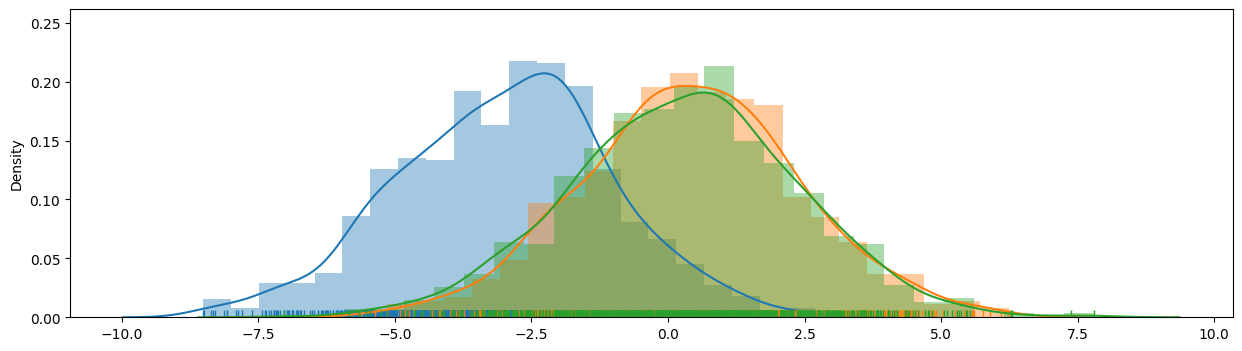

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
for c in range(0,num_components):
  sns.distplot(X[SAMPLE*c:SAMPLE*(c+1)], ax=ax, rug=True)


In [ ]:
ugmm = UGMM(X, num_components)
ugmm.fit()

Init mean
[-1.31844583  3.30315061 -5.29992206]
Init s2
[0.83872169 0.7912409  0.69100779]
Init N
3000
Init X
[-1.61484008  0.51206796 -4.09565443 ...  4.10589744 -1.28332063
  0.09938134]
range of X (min-max)
[-8.510202762400722, 7.791165580553187]
---End Init---
5 [-0.93631665  1.91441552 -3.97860644]
10 [-0.88154866  1.93620473 -3.91818229]
15 [-0.86463489  1.94625741 -3.90405397]
20 [-0.85953464  1.94932568 -3.89984607]
25 [-0.85799651  1.95025167 -3.89857838]
30 [-0.85753253  1.95053104 -3.89819607]
35 [-0.85739256  1.95061532 -3.89808075]
40 [-0.85735033  1.95064074 -3.89804596]
45 [-0.85733759  1.95064841 -3.89803546]
50 [-0.85733375  1.95065073 -3.89803229]
55 [-0.85733259  1.95065142 -3.89803134]
60 [-0.85733224  1.95065164 -3.89803105]
65 [-0.85733214  1.9506517  -3.89803096]
70 [-0.8573321   1.95065172 -3.89803094]
75 [-0.85733209  1.95065172 -3.89803093]
80 [-0.85733209  1.95065173 -3.89803093]
85 [-0.85733209  1.95065173 -3.89803093]
90 [-0.85733209  1.95065173 -3.89803093

In [ ]:
ugmm.phi.argmax(1)

array([0, 0, 2, ..., 1, 0, 0])

In [ ]:
sorted(mu_arr)

[-3.0382263355164447, 0.2687696210399898, 0.32550868629959384]

<ipython-input-10-ad39cc79aae4>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[SAMPLE*c:SAMPLE*(c+1)], ax=ax, hist=True, norm_hist=True) # true distributuoin plots
<ipython-input-10-ad39cc79aae4>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.random.normal(ugmm.m[c], variance, 

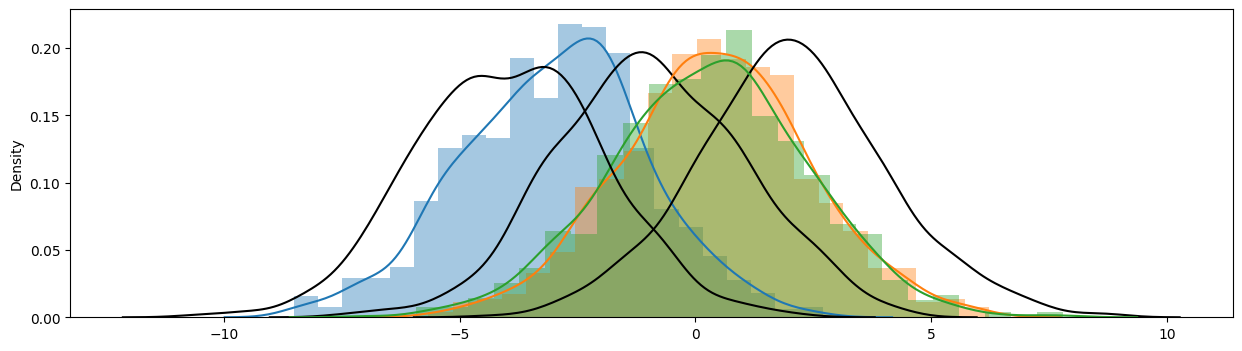

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
for c in range(0,num_components):
  sns.distplot(X[SAMPLE*c:SAMPLE*(c+1)], ax=ax, hist=True, norm_hist=True) # true distributuoin plots
  sns.distplot(np.random.normal(ugmm.m[c], variance, SAMPLE), color='k', hist=False, kde=True) # inference plots
